In [1]:
from fastai.vision import *
from fastai.tabular import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
pwd

'/home/ab/Projects/wine_quality'

In [5]:
data_path = Path('wine_quality')

In [6]:
train_df = pd.read_csv('white_wines.csv')
print(len(train_df))

4898


In [7]:
train_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [8]:
train_df['quality'].value_counts(normalize=True)

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

In [9]:
train_df['quality'] = train_df['quality'].replace([3,4,5,6,7,8,9,],
        [0,0,0,1,1,1,1])

In [10]:
train_df['quality'].value_counts(normalize=True)

1    0.665169
0    0.334831
Name: quality, dtype: float64

In [11]:
train_df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

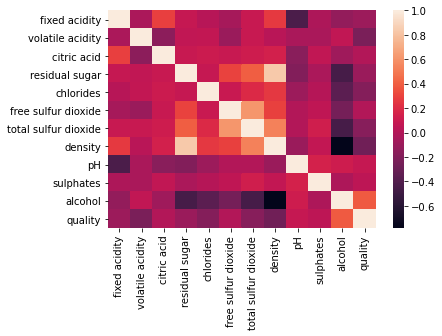

In [12]:
sns.heatmap(train_df.corr())

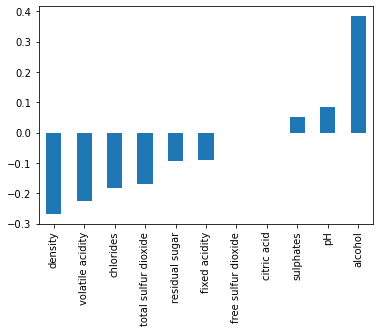

In [13]:
train_df.corr()['quality'][:-1].sort_values().plot(kind='bar')

In [17]:
train_df['quality'] = train_df['quality'].replace([0,0,0,1,1,1,1],
        ['Good','Good','Good','Excellent','Excellent','Excellent',
         'Excellent'])

In [18]:
train_df['quality'].value_counts(normalize=True)

Excellent    0.665169
Good         0.334831
Name: quality, dtype: float64

In [19]:
def get_valid_index(df, valid_pct:float=0.2, seed:int=0):
    np.random.seed(seed)
    rand_idx = np.random.permutation(range_of(df))
    cut = int(valid_pct * len(df))
    val_idx = rand_idx[:cut]
    return val_idx
# idx for validation
val_idx = get_valid_index(train_df)
len(val_idx)

979

In [20]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [21]:
train_df = train_df.drop(['citric acid','free sulfur dioxide'], axis=1)

In [22]:
dep_var = 'quality'
cat_names = []
cont_names = ['volatile acidity','chlorides','density','pH', 'alcohol',
            'sulphates','fixed acidity','total sulfur dioxide','residual sugar']
procs = [FillMissing, Categorify, Normalize]
bs=64

In [23]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names,
            cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var)
            .databunch(bs=bs))

In [24]:
tab_data.show_batch(rows=5)

volatile acidity,chlorides,density,pH,alcohol,sulphates,fixed acidity,total sulfur dioxide,residual sugar,target
0.4131,-0.5392,-0.8207,1.1405,1.6068,1.8994,-0.5498,-0.3896,-0.2939,Excellent
0.0150,-0.7210,-0.8070,-0.7164,1.6068,0.8613,-0.0651,-0.6738,0.2468,Excellent
1.7071,-0.7210,-1.1959,-1.4459,0.2285,-1.8203,-0.5498,-0.1764,-1.0548,Good
-0.6817,0.0515,-0.8207,-0.3848,0.1474,-0.6958,-0.0651,-0.6501,-1.0348,Excellent
0.4131,-0.7210,-0.9571,1.1405,1.6068,0.9478,-0.5498,-0.8869,-0.3139,Excellent


In [25]:
learn = tabular_learner(tab_data, layers=[200,100], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


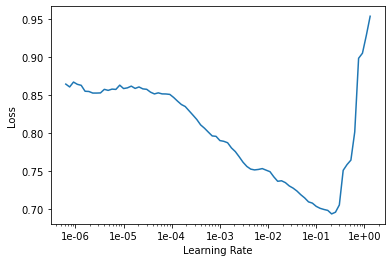

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(50, (1e-4)/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.855048,0.812026,0.432074,00:00
1,0.828676,0.782058,0.458631,00:00
2,0.794832,0.746610,0.499489,00:00
3,0.750485,0.700777,0.572012,00:00
4,0.699648,0.661750,0.613892,00:00
5,0.662221,0.630225,0.636364,00:00
6,0.632125,0.603210,0.663943,00:00
7,0.610514,0.591328,0.699694,00:00
8,0.595442,0.573757,0.718080,00:00
9,0.583984,0.572236,0.730337,00:00


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

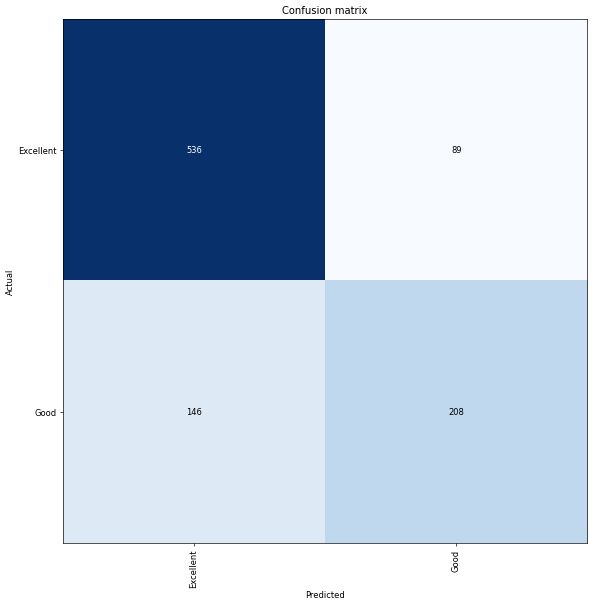

In [30]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)